**Dependencies**

In [1]:
# !pip3 install swifter
# !pip3 install xgboost
# !pip3 install tqdm
# !pip3 install category_encoders
# !pip3 install joblib
# !pip3 install scikit-plot 
# !pip3 install catboost
# !pip3 install RegscorePy

## FUNCTIONS

In [2]:
################################ ALL IMPORTS ################################
import warnings
warnings.filterwarnings('ignore')

# FOR INIT
import pandas as pd
import numpy as np
import swifter

# FOR Visualization
import matplotlib.pyplot as plt

# For Date Engineering
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import itertools
import holidays

# For numeric Engineering
import time

# For Target Encoding
from category_encoders import TargetEncoder

# For feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif, f_regression
from sklearn.ensemble import ExtraTreesClassifier

# POST PROCESS AND MACHINE LEARNING
from sklearn.preprocessing import PowerTransformer, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, mean_absolute_error,r2_score
from xgboost import XGBClassifier,XGBRegressor
from tqdm import tqdm_notebook as tqdm
import scikitplot as skplt
import joblib

# For debugging
import pdb

**INPUT**

In [3]:
def importFile(path,nrows=None):

    print('#### RUNNING WAIT ####')
    
    # IF THE EXTENSION IS CSV
    def importCsv(path):
        
        print('We have a csv file')
        try:
            df = pd.read_csv(path,low_memory=False,nrows=nrows)
            if df.shape[1] == 1:
                df = pd.read_csv(path,low_memory=False,sep=';',nrows=nrows)                
            print('This file has {} columns and {} rows'.format(df.shape[1],df.shape[0]))
            return df       
            
        except FileNotFoundError:
            print('File not found, Check the name, path, spelling mistakes')
            error = True
            return None    
            
        except UnicodeDecodeError:
            try:
                enc = 'unicode_escape'
                df = pd.read_csv(path,encoding=enc,low_memory=False,nrows=nrows)
                print('This file has {} columns and {} rows'.format(df.shape[1],df.shape[0]))
                return df
                
            except UnicodeDecodeError:
                try:
                    enc = 'ISO-8859-1'
                    df = pd.read_csv(path,encoding=enc,low_memory=False,nrows=nrows)
                    print('This file has {} columns and {} rows'.format(df.shape[1],df.shape[0]))
                    return df
                except:
                    pass
          
        except:
            try:
                df= pd.read_csv(path,nrows=nrows)
                separators= ["~","!","@","#","$","%","^","&","*",":","|","/",";"]     # all possible separators
                if len(df.columns)<=3 :                                               # if separator was "," we would have more than 1 columns 
                    cols = df.columns[0]
                    possibleSep = []   
                    for i in separators:                                    # checking all the separators present in column names
                        if i in cols:
                            possibleSep.append(i)
                        
                    for j in possibleSep:                                   # iterate through possible seprators till we get the correct one
                        df_sep = pd.read_csv(path,sep=j,nrows=nrows)
                        if len(df_sep.columns)>3:
                            print('This file has {} columns and {} rows'.format(df_sep.shape[1],df_sep.shape[0]))
                            return df_sep
            except:
                try:
                    if len(pd.read_csv(path,sep=None).columns,nrows=nrows)>3  :                   # for tab ie "\" tsv files
                        df = pd.read_csv(path,sep=None,nrows=nrows)
                        print('This file has {} columns and {} rows'.format(df.shape[1],df.shape[0]))
                        return df
                except:        
                    pass

    # IF THE EXTENSION IS JSON
    def importJSON(path):
        try:
            print('We have a JSON file')
            df = pd.read_json(path)
            print('This file has {} columns and {} rows'.format(df.shape[1],df.shape[0]))
            return df    
        except Exception:
            try:
                df = pd.read_json(path,lines=True)
                print('This file has {} columns and {} rows'.format(df.shape[1],df.shape[0]))
                return df
        
            except ValueError:
                print('File not found, Check the name, path, spelling mistakes')
                error = True
                return None

    def Excel_handler(dx):
        # to handel cases when some blank rows or other information above the data table gets assumed to be column name 
        if (len([col for col in dx.columns if 'Unnamed' in col]) > 0.5*dx.shape[1]  ):#Checking for unnamed columns 
            colNew = dx.loc[0].values.tolist()           # Getting the values in the first row of the dataframe into a list
            dx.columns = colNew                          #Making values stored in colNew as the new column names
            dx = dx.drop(labels=[0])                     #dropping the row whose values we made as the column names
            dx.reset_index(drop=True, inplace=True)      #resetting index to the normal pattern 0,1,2,3...
        else:
            return dx
            
        new_column_names=dx.columns.values.tolist() # Following three lines of code are for counting the number of null values in our new set of column names
        new_column_names=pd.DataFrame(new_column_names)
        null_value_sum=new_column_names.isnull().sum()[0]
        if null_value_sum<0.5*dx.shape[1]: # if count of null values are less than a certain ratio of total no of columns
            return dx
        while(null_value_sum>=0.5*dx.shape[1]): 
            colNew = dx.loc[0].values.tolist()
            dx.columns = colNew
            dx = dx.drop(labels=[0])
            dx.reset_index(drop=True, inplace=True)
            new_column_names=dx.columns.values.tolist() 
            new_column_names=pd.DataFrame(new_column_names)
            null_value_sum=new_column_names.isnull().sum()[0]
        return dx 

    # IF THE EXTENSION IS XL
    def importExcel(path):
        try:
            print('We have an Excel file')
            df = pd.read_excel(path, sheet_name=None,nrows=nrows)
            if len(df.keys())==1 :                               # checking if number of sheets is 1
                df = Excel_handler(df[list(df.keys())[0]])
                print('This file has {} columns and {} rows'.format(df.shape[1],df.shape[0]))
                return df
            else:                                                 # when more than 1 sheets, asking the user for data sheet name/number
                print("Following are the sheets in the Excel file:")
                for c in range(len(df.keys())):
                    print(str(c)+".",list(df.keys())[c])
                sheet = input("Type the sheet name:  ")
                keys = [x.lower() for x in list(df.keys())]
                try:
                    index = keys.index(sheet.lower())
                    df = Excel_handler(df[list(df.keys())[index]])
                    print('This sheet {} has {} columns and {} rows'.format(sheet,df.shape[1],df.shape[0]))
                    return df
                except:
                    print('Sheet not found, Check the name, path, spelling mistakes')
                    error = True
                    return None
        except FileNotFoundError:
            print('File not found, Check the name, path, spelling mistakes')
            error = True
            return None


    def importTable(path):
        try:
            print('We have General Table File')
            df = pd.read_table(path,nrows=nrows)
            if df.shape[1] == 1:
                df = pd.read_table(path,sep=',',nrows=nrows)
            print('This file has {} columns and {} rows'.format(df.shape[1],df.shape[0]))
            return df
        except FileNotFoundError:
            print('File not found, Check the name, path, spelling mistakes')
            error = True
            return None
            
            
    try:
        ext = path.split('.')[1].lower()    
        if ext == 'csv' or ext == 'tsv':
            df = importCsv(path)
            return df
        elif ext == 'json':
            df = importJSON(path)
            return df
        elif 'xl' in ext:
            df = importExcel(path)
            return df
        elif ext == 'data':
            df = importTable(path)
            return df
        else:
            print('File format not supported\n')
    except:
        print('Extension NOT FOUND!')

**GETTING TARGET**

In [4]:
def getTarget(columns):
  
    print('\nEnter \'quit\' to quit')
    target = input('What would you like to predict? : ')
    if target == 'quit':
        return None                    
    elif target in columns:
        print('Target Spotted!')
        return target
    else:
        print('Target {} Not found in the data'.format(target))
        return None

**KEY**

In [5]:
def getKey(columns):
    print('\nEnter \'quit\' to quit')
    key = input('Enter the Key/Identification Column : ')
    if key == 'quit':
        return None,False              
    elif key in columns.values:
        print('Key Spotted!')
        return key
    else:
        print('Key {} Not found in the data'.format(key))
        print('Preview can\'t be shown!!')
        return None

### Find Key if user didn't specify key from first column alone

In [6]:
def findKey(column):
    if 'id' in column.lower():
        dec = input("Is the column \'{}\' an identification column? If yes, enter y : ".format(column))
        if dec == 'y':
            print('Identification column obtained')
            return column
        else:
            print('Identification column not obtained/found')
            return None

**USER SPECIFIED**

In [7]:
def removeUserSpecifiedIDs(df,successiveTarget=False):
    removed_cols = set()
    not_found_cols = set()
    if not successiveTarget:
        print('Would you like to remove any other ID,zip Code,Phone Numbers,UNIQUE lists, ')
        print('Or columns that have only one unique entry? If yes, enter the column names below ')
    else:
        print('Do you think you have Successive Targets based on the current target? If yes, enter the column names below ')
    print('in this format separated by commas: col1,col2,col3')
    cols = input()
    if not cols:
        print('No Columns removed')
        return df
    else:
        try:
            columns = cols.split(',')
            for column in columns:
                if column in df.columns:
                    df.drop(column,axis=1,inplace=True)
                    removed_cols.add(column)
                else:
                    not_found_cols.add(column)
            if removed_cols:
                print('\n{} columns are removed as entered by the user'.format(len(removed_cols)))
            if not_found_cols:
                print('\n{}'.format(not_found_cols))
                print('These columns were not found, hence not removed')
            return df
        except:
            print('Invalid Entry of columns! No Columns removed')
            return df

**Identify Date Columns**

In [8]:
######################## ----------------- DATE IDENTIFICATION --------------------- ######################

# Global List of all months
months = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']

def getDateColumns(df,withPossibilies=0):
    '''
    This method Identifies all columns with 'DATE' data by maximizing out the possibilities
    '''
    # First get all non-numerical Columns
    non_numeric_cols = df.select_dtypes('object')
    # This dictionary stores possibilities of a column containing 'DATES' based on the name of the column
    Possibility = {}
    for column in non_numeric_cols:
        if 'date' in column.lower():                  
            Possibility[column] = int(len(df)*0.1)
        else:
            Possibility[column] = 0
        for entry in df[column]:                                                    # ITERATE THROUGH EVERY ENTRY AND TRY SPLITTING THE VALUE AND INCREMENT/DECREMENT POSSIBILITY 
            try:                                                                      # USING EXCEPTION HANDLING
                if len(entry.split('/')) == 3 or len(entry.split('-')) == 3 or len(entry.split(':')) == 3:
                    Possibility[column] += 1
                    for month in months:
                        if month in entry.lower():
                            Possibility[column] += 1 
                else:
                    Possibility[column] -= 1
            except:
                Possibility[column] -= 1        
      # This contains the final DATE Columns
    DATE_COLUMNS = []
    for key,value in Possibility.items():             
        if value > 0.8 * len(df):                                                  # IF THE POSSIBILITY OF THE COLUMN IN GREATER THAN 1, THEN IT IS DEFINITELY A 'DATE COLUMN'
            DATE_COLUMNS.append(key)    
    if not withPossibilies:
        return DATE_COLUMNS
    else:
        return DATE_COLUMNS,Possibility

**Date Engineering**

In [9]:
def date_engineering(df):
    start = time.time()
    date_cols = df.columns
    print('\n\t Entering Date Engineering')
    df = pd.to_datetime(df.stack(),infer_datetime_format=True,errors='coerce').unstack()
    df.fillna(pd.datetime.now(),inplace=True)
    
    # creating separate month and year columns
    for i in date_cols:
        df[str(i)+"_month"] = df[str(i)].dt.month.astype(int)
        df[str(i)+"_year"] = df[str(i)].dt.year.astype(int)
    
    # create difference columns
    if (len(date_cols)>1) :
        for i in itertools.combinations(date_cols,2):
            df[str(i[0])+" - "+str(i[1])]=(df[i[0]]-df[i[1]]).dt.days.astype(int)
    
    # create most recent
    for i in date_cols:
        df[str(i)+"-most_recent"] = (max(df[str(i)])-df[str(i)]).dt.days.astype(int)
    
    print('\n\t #### RUNNING WAIT ####')
    
    # See Near Holiday or not 
    def nearHol(currentDate, us_hols, currentYear):
        new_list = []
        append = new_list.append
        for date, occasion in us_hols:
            if(date.year == currentYear):
                append(date)
        flag = 1
        for i in new_list:
            a = (currentDate.date()-i).days

            if abs(a)<=5:flag =1;break
            else:flag = 0
                
        return 0 if flag == 0 else 1
        
    for col in date_cols:
#         print('LOOP')
        #creating a unique list of all years corresponding to a column to minimise mapping
        us_hols = holidays.US(years=df[str(col)+'_year'].unique(), expand= False) 
        #creating a new columns to check if a date falls near a holiday
        df[str(col)+'_Holiday'] = df.apply(lambda x: nearHol(x[col],us_hols.items(),x[str(col)+'_year']),axis=1) 
    
    end = time.time()
    print('\nDate Engineering Time Taken : {}'.format(end-start))
    print('\n\t #### DONE ####')
    return df.drop(date_cols,axis=1)

**Numeric Engineering**

In [10]:
# Numeric Engineering 1(To be tested)
#For converting allnumeric data in columns like currency remperature, numbers in numeric form etc.. into numeric form
def numeric_engineering(df):
    start = time.time()  
    
    def returnMoney(col):
        # Remove Commas from currencies
        try:
            return pd.to_numeric(col.str.replace(',',''))
        except:
            return col
        
    obj_columns= list(df.dtypes[df.dtypes == np.object].index)
    # print(f'object type columns are {obj_columns}') 
    print(f'\t\t stripping spaces, symbols, and lower casing all entries')
    df[obj_columns]=df[obj_columns].swifter.apply(lambda x: x.astype(str).str.strip(' %$€£¥').str.lower())
    print('done ...')
    print(f'\t\t Replacing empty and invalid strings')
    df[obj_columns]=df[obj_columns].replace(['-','n/a','na','nan','nil',np.inf,-np.inf],[np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan])
    print('done ...')
    print(f'\t\t Replacing commas if present in Currencies')
    df[obj_columns]=df[obj_columns].swifter.apply(lambda x:returnMoney(x))
    print('done ...')
    obj_columns= list(df.dtypes[df.dtypes == np.object].index)
    df1 = df[obj_columns].copy()
    print(f'\t\t Finding Numeric Columns')
    df1 = df1.swifter.apply(lambda x : pd.to_numeric(x,errors='coerce'))
    df1.dropna(axis=1,thresh = 0.65*len(df),inplace=True)
    new_num_cols = df1.columns
    df[new_num_cols] = df[new_num_cols].swifter.apply(lambda x : pd.to_numeric(x,errors='coerce'))
    print('done ...')

    for i in df.columns :
        print(f'\t\t   {i} is of type {df[i].dtypes}')

    # # End of Testing codes
    end = time.time();print('Numeric Engineering time taken:',end - start);print('\n')
    return(df)

## Segregation

In [11]:
def Segregation(df):
    print('\n#### Entering Segregation ####')
    start = time.time()
    num = df._get_numeric_data().columns
    obj = list(set(df.columns)-set(num))
    
    nu = df[num].nunique()>5
    numeric = df[nu[nu == True].index]   
    cat_num = df[list(set(num) - set(numeric.columns))]
    numeric.fillna(numeric.mean(),inplace=True)
    cat_num.fillna('missing',inplace=True)
    
    unique = []
    discrete = []
    
    def func(column):
        l=column.value_counts(normalize=True)
        minor=l[l<=0.005].index
        if len(minor) > 0:
            print('\n{} contains {} categories that is/are less than 0.5 percent'.format(column.name, len(minor)))  
            if (column.nunique() - len(minor)) in range(1,61):
                discrete.append(column.name)
                column.replace(minor,'others',inplace=True)
            else:
                unique.append(column.name)
        else:
            discrete.append(column.name)
    
    df[obj].apply(func)
    
    for col in discrete:
        df[col].fillna('missing',inplace=True)
    
    print('\n Grouped Minor Levels and imputed')
    print('\n The useless columns are {}'.format(unique))
    end = time.time()
    print('Segregation time taken : {}'.format(end-start))
    return numeric,pd.concat([cat_num,df[discrete]],axis=1),unique

**Dataset Selection**

In [12]:
def DatasetSelection(X,Y):
  X1=X.copy()
  X2=X.copy()
  index=list(X.index)
  #Row then column
  X1.dropna(axis=0,thresh=0.5*len(X1.columns),inplace=True)#dropping the rows with many null values
  index1=list(X1.index)#storing the indices of the dataframe after the operation in index1
  X1.dropna(axis=1,thresh=0.5*len(X1),inplace=True)#dropping columns
  if len(X1.columns)==0:#in case if all columns get dropped then in result there should be no rows in the dataframe
    index1=[] #in this case list of row indices equal to null list
  Rowsdrop1=(list(set(index)-set(index1)))#storing the indices of the rows getting dropped above
  #column then row
  X2.dropna(axis=1,thresh=0.5*len(X2),inplace=True)#dropping the columns with many null values
  X2.dropna(axis=0,thresh=0.5*len(X2.columns),inplace=True)#dropping rows
  index2=list(X2.index)#storing its indices in a list
  if len(X2.columns)==0:
    index2=[]
  Rowsdrop2=(list(set(index)-set(index2)))#storing the indices of the rows getting dropped above
  if len(Rowsdrop1)<len(Rowsdrop2): #checking in which case is number of rows getting dropped is lesser
    Y.drop(Rowsdrop1,inplace=True)
    print("Columns are getting dropped first then columns")
    print("The columns getting dropped are {}".format(list(set(X.columns)-set(X1.columns))))
    print("Shape of the dataframe: {}".format(X1.shape))
    print("Shape of the target column {}".format(Y.shape))
    return X1,Y #returns resultant dataframe and target column
  else:
    Y.drop(Rowsdrop2,inplace=True)  
    print("Rows are getting dropped first then rows")
    print("The columns getting dropped are {}".format(list(set(X.columns)-set(X2.columns))))
    print("Shape of the dataframe: {}".format(X2.shape))
    print("Shape of the target column {}".format(Y.shape))
    return X2,Y

**TARGET ANALYSIS**

In [13]:
def targetAnalysis(df):
    print('\n### TARGET ANALYSIS ENTERED ###')
    Type = str(df.dtypes)
    # IF INT OR FLOAT IN TARGET, and IF NUMBER OF UNIQUE IS LESS, CLASSIFICATION, ELSE, REGRESSION
    print('Target has {} unique values'.format(df.nunique()))
    if ('int' in Type) or ('float' in Type):
        if df.nunique() < 5:
            return 'Classification'
        else:
            return 'Regression'
        
    else:
        if df.nunique() < 5:
            return 'Classification'
        else:
            return None

**Sample Equation**

In [14]:
def SampleEquation(X,Y,class_or_Reg):
    if class_or_Reg == 'Classification':# for classification
        from sklearn.linear_model import LogisticRegression
        model=LogisticRegression(max_iter=400)
        kb = SelectKBest( score_func=f_classif,k=8) #for selecting the 8 best features
        if len(X.columns)>8:#to limit the size of equation. restricting to be less than 9 variables 
            kb.fit_transform(X,Y) 
            new_features = []
            mask=kb.get_support() #This returns an array with true /false values with true for those columns which got selected
            for bool, feature in zip(mask,X.columns):#to extract column names from mask
                if bool:
                    new_features.append(feature)
            X=X[new_features]

        model.fit(X,Y)
        if Y.nunique()==2: #if there are only two classes
            for i in range(len(model.coef_)): # for dispaying the equation curresponding to all classes
                s=""
                for j in range(len(model.coef_[i])):
                    s=s+str(model.coef_[i][j])+"*"+X.columns[j]+" + "
                s=s+str(model.intercept_[i])

                print("Power term = "+s+"\n")
                print("Probability(Y=1) = exp(Power term)/(exp(Power term) + 1)\n")
        else:#multiclass classification
            for i in range(len(model.coef_)): # for dispaying the equation curresponding to all classes
                s=""
                for j in range(len(model.coef_[i])):
                    s=s+str((model.coef_[i][j]))+"*"+X.columns[j]+" + "
                s=s+str(model.intercept_[i])

                print("Prediction of class "+ str(model.classes_[i])+"\n\n")
                print("Power term= " + s)
                print("\nPrediction(class={}) = exp(Power term)/(exp(Power term) + 1)\n".format(model.classes_[i]))
    else:#regression problem
        from mlxtend.feature_selection import SequentialFeatureSelector as SFS
        from sklearn.linear_model import LinearRegression
        model=LinearRegression()
        if len(X.columns)>8:#Executing forward feature selection
            sfs = SFS(model,
               k_features=8,
               forward=True,
               floating=False,
               scoring = 'r2',
               cv = 0)
            sfs.fit(X,Y)
            X=X[list(sfs.k_feature_names_)] 
        model.fit(X,Y)
        coeff=model.coef_
        equation=""
        for i in range(len(coeff)):
            equation= equation+str(coeff[i])+"*"+X.columns[i]+" + "
        equation=equation+str(model.intercept_)

        print('Linear Equation is : {}'.format(equation))

## Feature Selection

In [15]:
def FeatureSelection(X,y,class_or_Reg):
    n_est = 10
    if class_or_Reg == 'Classification': 
        selector = XGBClassifier(n_estimators =n_est, max_depth= 6, n_jobs=-1)
        print('runnning classifier selector')
    else : 
        selector = XGBRegressor(n_estimators =n_est, max_depth= 6, n_jobs=-1)
        print('runnning regressor selector')
    
    for i in tqdm(range(10)):
        selector.fit(X, y) 
    
    # all columns container
    cols = pd.DataFrame(X.columns)

    # Getting importance scores of all the features
    k = selector.feature_importances_
    k = k.reshape(X.shape[1],1)
    k = pd.DataFrame(k)

    # threshold one(This thres is able to select only top best features which are very few)
    thresh1 = k.mean(); l = k>thresh1
    sheet1 = pd.concat([cols, k, l], axis =1)
    sheet1.columns = ['col_name','scores1','t/f']
    new_1 = sheet1.loc[(sheet1['t/f'] == False)] 

    # threshold two(The mean of the remaining features is used as a thres)
    thresh2 = new_1['scores1'].mean(); l2 = k>thresh2
    sheet2 = pd.concat([cols, k, l2], axis =1)
    sheet2.columns = ['col_name','scores2','t/f']
    new_2 = sheet2.loc[(sheet2['t/f'] == True)]

    # Final Score Sheet
    new_2 = new_2.sort_values('scores2', ascending=False)
    print('\nThe final score sheet of {} selected columns with importances:\n' .format(new_2.shape[0]))
    print(new_2)
    
    rejected_cols = set(X.columns) - set(new_2.col_name)
    print('\n{} columns are eliminated during Feature Selection which are:\n{}' .format(len(rejected_cols), rejected_cols))
    return list(rejected_cols),new_2.drop(['t/f'],axis=1)

## User Interact Visualization

In [16]:
def bivar_ploter(df1,targ,base_var,ax1):    
      l=[]
      for b in set(df1[targ]):l.append((df1[df1[targ]==b].groupby(base_var).count()[targ]).rename(b))
      c=pd.concat(l,axis=1)
      if(df1[targ].nunique()>5):
          a=list(c.sum(axis=0).sort_values(ascending=False)[:4].index)
          c=pd.concat([c[a],pd.Series(c[list(set(c.columns)-set(a))].sum(axis=1),name='Others')],axis=1)
      if(df1[base_var].dtype==np.object or df1[base_var].nunique()/len(df1)>0.1):
          if(df1[base_var].nunique()<10):a=c.plot(kind='bar',ax=ax1)
          else:a=c.loc[list(c.sum(axis=1).sort_values().index)[-10:]].plot(kind='bar',ax=ax1)
          ax1.set_title(base_var)
      else:
          a=c.plot(kind='line',alpha=0.5,ax=ax1)
      ax1.set_ylabel('Frequency')
      return a

In [17]:
def userInteractVisualization(df1,targ):
        B=list(df1.columns);B.remove(targ);l=[]
        x=df1.apply(lambda x:np.sum(x.value_counts(normalize=True).iloc[:min(10,x.nunique())])<0.10)
        if(df1[targ].nunique()>4 and df1[targ].dtype!=np.object):j=np.sum(df1.dtypes==np.object)-np.sum(x)
        else:j=len(df1.columns)-np.sum(x & df1.dtypes==np.object)-1
        nr=int((j/4)+0.99)
        print('\t Applying bivar_plotting to create Images ...') # For Testing
        start = time.time() 
        fig, axes = plt.subplots(ncols=4,nrows=nr,figsize=(20,6*nr));axes=axes.ravel();i=0
        if(df1[targ].nunique()>5 and df1[targ].dtype!=np.object):        
            for c in (df1.dtypes.loc[(df1.dtypes==np.object).values].index):
                #Plots for cat features done if top 10 unique_values account for >10% of data (else visulaisation is significant)
                if(np.sum(df1[c].value_counts(normalize=True).iloc[:min(10,df1[c].nunique())])<0.10):continue
                try:
                    bivar_ploter(df1,c,targ,axes[i]);i=i+1
                except:
                    pass
        else:    
            for c in B:
                #Plots for cat features done if top 10 unique_values account for >10% of data (else visulaisation is significant)
                if(np.sum(df1[c].value_counts(normalize=True).iloc[:min(10,df1[c].nunique())])<0.10 and df1[c].dtype==np.object):continue
                try:
                    bivar_ploter(df1,targ,c,axes[i]);i=i+1
                except:
                    pass
        for c in range(i,(4*nr)):axes[c].set_visible(False)
        print('\n Target analysis');fig.suptitle(targ);fig.tight_layout();fig.show()
        print(f'\t Done with Bivar plotting in time {time.time() - start} seconds ')

# CLASSIFICATION

In [18]:
import pandas as pd
import os 
import numpy as np
import random
from pprint import pprint
from itertools import combinations
import ast # ast.literal_eval(str(best))
from time import process_time 
import time
from decimal import Decimal

# Model
import xgboost as xgb
import catboost as cb
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn import svm
from sklearn.naive_bayes import GaussianNB

#Hyperopt
import hyperopt
from hyperopt import *
from hyperopt.pyll.base import scope
from hyperopt.pyll.stochastic import sample

#sklearn library
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import matthews_corrcoef
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import classification_report
from sklearn.utils import compute_sample_weight

import xgboost as xgb
from scipy.stats import ks_2samp

class classification:
    
  #This funciton takes input of training and testing datasets and give out the best model's Name, model with best parameter(can be used directly to score data using 'predcit' function), accuracy on the test dataset and parameters (not usefful)
  ###############################################################################################################################
  def best_model_class(self,X_train ,X_test, y_train, y_test,priorList,MAX_EVALS=2,CV=5):
      df=pd.DataFrame()
      ind=0
      #XGBoost   
      #########################################################################################################################
      ##XGBoost(1) Finding Best hyperparamter using Bayesian Hyperparameter Optimization
      ########################################################################################################
      def objective(params):
          print(params)
          xg = xgb.XGBClassifier(**params)
          result=cross_val_score(xg,X=X_train,y=y_train,cv=CV,scoring='accuracy',error_score=np.nan,n_jobs=-1)
          print("XGB train done")
          print(result.min()*100)
          return (1-result.min())
    
      sample_weight = compute_sample_weight('balanced', y_train)   
      Space = {
              'n_estimators': scope.int(hp.quniform('n_estimators', 75,1250,75)),
              'eta': hp.uniform('eta', 0.01,0.1 ),
              'max_depth':  scope.int(hp.quniform('max_depth',3,30,2 )),
              'min_child_weight':  scope.int(hp.quniform('min_child_weight',0,50,2 ))+1,
              'colsample_bytree': hp.uniform('colsample_bytree', 0.2,1.0 ),
              'eval_metric':'error',
              'subsample': hp.uniform('subsample',  0.2,1.0  ),
              # 'sample_weight':sample_weight
              }

      
      bayes_trials = Trials()
      print("Moving into HyperOp")
      best = fmin(fn=objective, space = Space, algo = hyperopt.tpe.suggest,max_evals=MAX_EVALS, trials = bayes_trials)
      print("HyperOP done for XGB")
        
      best['n_estimators']=int(best['n_estimators'])
      best['max_depth']=int(best['max_depth'])
      best['min_child_weight']=int(best['min_child_weight']+1)
      best['eval_metric']='error'
      # best['sample_weight']=sample_weight
      print('XGB done')
      ########################################################################################################
      

      ##XGBoost(2) Finding out accuracy on the test dataset
      ########################################################################################################
      df.loc[ind,'Name']='XGBoost'
      df.loc[ind,'model']=xgb.XGBClassifier(**best)
      df.loc[ind,'param']=str(best)
      Start=time.time()
      df.loc[ind,'model'].fit(X_train, y_train)
      xgb_pred = df.loc[ind,'model'].predict(X_test)
      End=time.time()
      df.loc[ind,'accuracy']=accuracy_score(y_test, xgb_pred)*100
      df.loc[ind,'Accuracy_Percent']="{:.2%}".format(Decimal(str(accuracy_score(y_test, xgb_pred))))
      df.loc[ind, 'Precision']=precision_score(y_test, xgb_pred)
      df.loc[ind, 'Recall']=recall_score(y_test, xgb_pred)
      df.loc[ind, 'F1']=f1_score(y_test, xgb_pred)
      df.loc[ind, 'ROC_AUC_score']=roc_auc_score(y_test, xgb_pred)
      df.loc[ind, 'Kappa']=cohen_kappa_score(y_test, xgb_pred)
      df.loc[ind, 'MCC']=matthews_corrcoef(y_test, xgb_pred)
      df.loc[ind, 'K-S_statistic'],df.loc[ind, 'K-S_p-value']=ks_2samp(y_test, xgb_pred)
      df.loc[ind, 'Total time(m)']=End-Start      
      print("XGB val done")
      ind=ind+1
      ########################################################################################################
      
      
      #Catboost
      #########################################################################################################################
      ##Catboost(1) Finding Best hyperparamter using Bayesian Hyperparameter Optimization
      ########################################################################################################
      def objective(params):
          print('\n',params)
          cb1 = cb.CatBoostClassifier(**params)
          result=cross_val_score(cb1,X=X_train,y=y_train,cv=CV,scoring='accuracy',error_score=np.nan,n_jobs=-1)
          print("CAT train done")
          print('\n',1-result.min())
          return (1-result.min())
            
      Space = {
                  'silent': True,
                  "depth": scope.int(hp.quniform('depth', 2, 10,1)),
                  'iterations': scope.int(hp.quniform('iterations',75,1250,75)),
                  'learning_rate': hp.uniform('learning_rate', 0.01,0.1 ),
                  'random_strength' : hp.uniform('random_strength', 0.01,10 ),
                  'bagging_temperature': scope.int(hp.quniform('bagging_temperature',  2,30,2 )),
                  'border_count': 254,
                  'rsm': hp.uniform('rsm',  0.01,1.0  ),
                  'auto_class_weights':'Balanced'
                  }
      
      
      bayes_trials = Trials()
      print("Moving into HyperOp")
      best = fmin(fn = objective, space = Space, algo = hyperopt.tpe.suggest,max_evals=MAX_EVALS, trials = bayes_trials)
      print("HyperOP done for CAT")
      
      best['depth']=int(best['depth'])
      best['iterations']=int(best['iterations'])
      best['bagging_temperature']=int(best['bagging_temperature'])
      best['border_count']=254
      best['silent']= True
      best['auto_class_weights']='Balanced'
      print("CAT done")
      ########################################################################################################
      

      ##Catboost(2) Finding out accuracy on the test dataset
      ########################################################################################################
      df.loc[ind,'Name']='CatBoost'
      df.loc[ind,'model']=cb.CatBoostClassifier(**best)
      df.loc[ind,'param']=str(best)
      Start=time.time()
      df.loc[ind,'model'].fit(X_train, y_train)
      catboost_pred = df.loc[ind,'model'].predict(X_test)
      End=time.time()
      df.loc[ind,'accuracy']=accuracy_score(y_test, catboost_pred)*100
      df.loc[ind,'Accuracy_Percent']="{:.2%}".format(Decimal(str(accuracy_score(y_test, catboost_pred))))
      df.loc[ind, 'Precision']=precision_score(y_test, catboost_pred)
      df.loc[ind, 'Recall']=recall_score(y_test, catboost_pred)
      df.loc[ind, 'F1']=f1_score(y_test, catboost_pred)
      df.loc[ind, 'ROC_AUC_score']=roc_auc_score(y_test, catboost_pred)
      df.loc[ind, 'Kappa']=cohen_kappa_score(y_test, catboost_pred)
      df.loc[ind, 'MCC']=matthews_corrcoef(y_test, catboost_pred)
      df.loc[ind, 'K-S_statistic'],df.loc[ind, 'K-S_p-value']=ks_2samp(y_test, catboost_pred)
      df.loc[ind, 'Total time(m)']=End-Start
      print("CAT val done")
      ind=ind+1
      ########################################################################################################
      

      #NaiveBayes
      ########################################################################################################
      
    
      best = {'priors': priorList}
      df.loc[ind,'Name']='Naive Bayes'
      df.loc[ind,'model']=GaussianNB(priors = priorList)
      df.loc[ind,'param']=str(best)
      Start=time.time()
      df.loc[ind,'model'].fit(X_train, y_train)
      naive_pred = df.loc[ind,'model'].predict(X_test)
      End=time.time()
      df.loc[ind,'accuracy']=accuracy_score(y_test, naive_pred)*100
      df.loc[ind,'Accuracy_Percent']="{:.2%}".format(Decimal(str(accuracy_score(y_test, naive_pred))))
      df.loc[ind, 'Precision']=precision_score(y_test, naive_pred)
      df.loc[ind, 'Recall']=recall_score(y_test, naive_pred)
      df.loc[ind, 'F1']=f1_score(y_test, naive_pred)
      df.loc[ind, 'ROC_AUC_score']=roc_auc_score(y_test, naive_pred)
      df.loc[ind, 'Kappa']=cohen_kappa_score(y_test, naive_pred)
      df.loc[ind, 'MCC']=matthews_corrcoef(y_test, naive_pred)
      df.loc[ind, 'K-S_statistic'],df.loc[ind, 'K-S_p-value']=ks_2samp(y_test, naive_pred)
      df.loc[ind, 'Total time(m)']=End-Start
      print("Naive Bayes done")
      ind=ind+1

      #Logistic regression
      ########################################################################################################
      best={'max_iter':1000, 'class_weight':'balanced'}
      df.loc[ind,'Name']='Logistic Regression'
      df.loc[ind,'model']=LogisticRegression(**best)
      df.loc[ind,'param']=str(best)
      Start=time.time()
      df.loc[ind,'model'].fit(X_train, y_train)
      log_pred = df.loc[ind,'model'].predict(X_test)
      End=time.time()
      df.loc[ind,'accuracy']=accuracy_score(y_test, log_pred)*100
      df.loc[ind,'Accuracy_Percent']="{:.2%}".format(Decimal(str(accuracy_score(y_test, log_pred))))
      df.loc[ind, 'Precision']=precision_score(y_test, log_pred)
      df.loc[ind, 'Recall']=recall_score(y_test, log_pred)
      df.loc[ind, 'F1']=f1_score(y_test, log_pred)
      df.loc[ind, 'ROC_AUC_score']=roc_auc_score(y_test, log_pred)
      df.loc[ind, 'Kappa']=cohen_kappa_score(y_test, log_pred)
      df.loc[ind, 'MCC']=matthews_corrcoef(y_test, log_pred)
      df.loc[ind, 'K-S_statistic'],df.loc[ind, 'K-S_p-value']=ks_2samp(y_test, log_pred)
      df.loc[ind, 'Total time(m)']=End-Start
      print("LR done")
      ind=ind+1
      
      #Neural net
      ########################################################################################################
      best={'hidden_layer_sizes':(50,100,100,50),'learning_rate':'adaptive','max_iter':1000}
      df.loc[ind,'Name']='Neural Net'
      df.loc[ind,'model']=MLPClassifier(**best)
      df.loc[ind,'param']=str(best)
      Start=time.time()
      df.loc[ind,'model'].fit(X_train, y_train)
      neural_pred = df.loc[ind,'model'].predict(X_test)
      End=time.time()
      df.loc[ind,'accuracy']=accuracy_score(y_test, neural_pred)*100
      df.loc[ind,'Accuracy_Percent']="{:.2%}".format(Decimal(str(accuracy_score(y_test, neural_pred))))
      df.loc[ind, 'Precision']=precision_score(y_test, neural_pred)
      df.loc[ind, 'Recall']=recall_score(y_test, neural_pred)
      df.loc[ind, 'F1']=f1_score(y_test, neural_pred)
      df.loc[ind, 'ROC_AUC_score']=roc_auc_score(y_test, neural_pred)
      df.loc[ind, 'Kappa']=cohen_kappa_score(y_test, neural_pred)
      df.loc[ind, 'MCC']=matthews_corrcoef(y_test, neural_pred)
      df.loc[ind, 'K-S_statistic'],df.loc[ind, 'K-S_p-value']=ks_2samp(y_test, neural_pred)
      df.loc[ind, 'Total time(m)']=End-Start
      print("NN done")
      ind=ind+1
      
      #Support Vector Machine
      ########################################################################################################     
      df.loc[ind,'Name']='Support Vector Machine'
      df.loc[ind,'model']=svm.SVC(probability=True,class_weight='balanced')
      df.loc[ind,'param']=None
      Start=time.time()
      df.loc[ind,'model'].fit(X_train, y_train)
      support_pred = df.loc[ind,'model'].predict(X_test)
      End=time.time()
      df.loc[ind,'accuracy']=accuracy_score(y_test, support_pred)*100
      df.loc[ind,'Accuracy_Percent']="{:.2%}".format(Decimal(str(accuracy_score(y_test, support_pred))))
      df.loc[ind, 'Precision']=precision_score(y_test, support_pred)
      df.loc[ind, 'Recall']=recall_score(y_test, support_pred)
      df.loc[ind, 'F1']=f1_score(y_test, support_pred)
      df.loc[ind, 'ROC_AUC_score']=roc_auc_score(y_test, support_pred)
      df.loc[ind, 'Kappa']=cohen_kappa_score(y_test, support_pred)
      df.loc[ind, 'MCC']=matthews_corrcoef(y_test, support_pred)
      df.loc[ind, 'K-S_statistic'],df.loc[ind, 'K-S_p-value']=ks_2samp(y_test, support_pred)
      df.loc[ind, 'Total time(m)']=End-Start
      print("SVC done ")
      ind=ind+1
      
      
      #Ensemble
      ########################################################################################################
      ##Ensemble(1) Finding all possible combination of above model and find out the best combination based on testing data accuracy
      ########################################################################################################
      lev=len(np.unique(y_test))
      arr1=np.empty((len(y_test),lev,0))
      for i in range(0,len(df)):
          arr1=np.dstack((arr1,df.loc[i,'model'].predict_proba(X_test)))

      max_acc=0
      max_seq=0
      for i in range(2,len(df)+1):
          comb=list(combinations(enumerate(np.rollaxis(arr1,axis=2,start=0)), i))
          for j in range(0,len(comb)):
              m=np.empty((len(y_test),lev,0))
              for x in range(0,len(comb[j])):
                  m=np.dstack((m,comb[j][x][1]))
              arr=np.mean(m,axis=2)
              clas=np.argmax(arr,axis=1)
              acc=accuracy_score(y_test, clas)*100
              seq=np.array(comb[j])[:,0]
              if acc>max_acc:
                  max_acc=acc
                  max_seq=seq
      ########################################################################################################

      ##Ensemble(2) List of the best combination from the above method
      ########################################################################################################  
      name=''
      df_en=pd.DataFrame()
      for i in range(0,len(max_seq)):
          df_en.loc[i,'Name']=df['Name'][max_seq[i]]
          df_en.loc[i,'model']=df['model'][max_seq[i]]
          name=name+df['Name'][max_seq[i]]+'+'
      ########################################################################################################
      
      
      ##Ensemble(3) Making an esemble model of the best combination
      ########################################################################################################
      df.loc[ind,'Name']=('Ensemble '+name)[:-1]
      df.loc[ind,'model']=VotingClassifier(df_en.values, voting='soft',n_jobs=-1)
      df.loc[ind,'param']="Default"
      Start=time.time()
      df.loc[ind,'model'].fit(X_train, y_train)
      ensemble_pred = df.loc[ind,'model'].predict(X_test)
      End=time.time()
      df.loc[ind,'accuracy']=accuracy_score(y_test, ensemble_pred)*100
      df.loc[ind,'Accuracy_Percent']="{:.2%}".format(Decimal(str(accuracy_score(y_test, ensemble_pred))))
      df.loc[ind, 'Precision']=precision_score(y_test, ensemble_pred)
      df.loc[ind, 'Recall']=recall_score(y_test, ensemble_pred)
      df.loc[ind, 'F1']=f1_score(y_test, ensemble_pred)
      df.loc[ind, 'ROC_AUC_score']=roc_auc_score(y_test, ensemble_pred)
      df.loc[ind, 'Kappa']=cohen_kappa_score(y_test, ensemble_pred)
      df.loc[ind, 'MCC']=matthews_corrcoef(y_test, ensemble_pred)
      df.loc[ind, 'K-S_statistic'],df.loc[ind, 'K-S_p-value']=ks_2samp(y_test, ensemble_pred)
      df.loc[ind, 'Total time(m)']=End-Start
      ind=ind+1

      ##Best Model
      ########################################################################################################
      best_info=df.sort_values('accuracy',ignore_index=True,ascending=False).loc[0,:]
      best_name=best_info['Name']
      best_mod=best_info['model']
      best_acc=best_info['accuracy']
      best_param=best_info['param']
      ########################################################################################################    
    
      joblib.dump(best_info,'best_info')
        
      return best_name,best_mod, best_acc, best_param,df

# REGRESSION

In [19]:
import pandas as pd
import os 
import numpy as np
import random
from pprint import pprint
from itertools import combinations
import ast # ast.literal_eval(str(best))
from time import process_time 
import time
from math import sqrt
from decimal import Decimal

# Model
import xgboost as xgb
import catboost as cb
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn import svm
from sklearn.linear_model import Ridge

#Hyperopt
import hyperopt
from hyperopt import *
from hyperopt.pyll.base import scope
from hyperopt.pyll.stochastic import sample



#sklearn library
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import classification_report

from RegscorePy import aic,bic

  ###############################################################################################################################
class Regression:

  #This funciton takes input of training and testing datasets and give out the best model's Name, model with best parameter(can be used directly to score data using 'predcit' function), accuracy on the test dataset and parameters (not usefful)
  ###############################################################################################################################
  def best_model_reg(self,X_train , X_test, y_train, y_test,MAX_EVALS=2,CV=5):
      df=pd.DataFrame()
      ind=0    
      
      #XGBoost
      #########################################################################################################################
      ##XGBoost(1) Finding Best hyperparamter using Bayesian Hyperparameter Optimization
      ########################################################################################################
      def objective(params):
          print(params)
          xg = xgb.XGBRegressor(**params)
          result=cross_val_score(xg,X=X_train,y=y_train,cv=CV,scoring='r2',error_score=np.nan,n_jobs=-1)
          print("XGB Training Done")
          return (1-result.min())
      
      
      Space = {
              'n_estimators': scope.int(hp.quniform('n_estimators', 75,1250,75)),
              'eta': hp.uniform('eta', 0.01,0.1 ),
              'max_depth':  scope.int(hp.quniform('max_depth',3,30,2 )),
              'min_child_weight':  scope.int(hp.quniform('min_child_weight',0,50,2 ))+1,
              'colsample_bytree': hp.uniform('colsample_bytree', 0.2,1.0 ),
              'eval_metric': 'rmse',
              'objective': 'reg:squarederror',
              'subsample': hp.uniform('subsample',  0.2,1.0  )
              }
      
      
      bayes_trials = Trials()
      best = fmin(fn = objective, space = Space, algo = hyperopt.tpe.suggest,max_evals=MAX_EVALS, trials = bayes_trials)
      print("XGB hyperop done")
      
      
      best['n_estimators']=int(best['n_estimators'])
      best['max_depth']=int(best['max_depth'])
      best['min_child_weight']=int(best['min_child_weight']+1)
      best['objective']='reg:squarederror'
      best['eval_metric']='rmse'
      ########################################################################################################
      

      ##XGBoost(2) Finding out accuracy on the test dataset
      ########################################################################################################
      df.loc[ind,'Name']='XGBoost'
      df.loc[ind,'model']=xgb.XGBRegressor(**best)
      df.loc[ind,'param']=str(best)
      Start = time.time()
      df.loc[ind,'model'].fit(X_train, y_train)
      xgb_reg_prob1 = df.loc[ind,'model'].predict(X_test).tolist()
      print(type(xgb_reg_prob1))
      End = time.time()
      df.loc[ind,'accuracy']=r2_score(y_test, xgb_reg_prob1)*100
      df.loc[ind,'Accuracy_Percent']="{:.2%}".format(Decimal(str(r2_score(y_test, xgb_reg_prob1))))
      df.loc[ind,'RMSE']=sqrt(mean_squared_error(y_test, xgb_reg_prob1))
      df.loc[ind,'MAE']=mean_absolute_error(y_test, xgb_reg_prob1)
      df.loc[ind,'AIC']=aic.aic(y_test, xgb_reg_prob1,X_train.shape[1])
      df.loc[ind,'BIC']=bic.bic(y_test, xgb_reg_prob1,X_train.shape[1])
      df.loc[ind,'Total time(s)']= End-Start
      
      print("XGB Validation done")
      ind=ind+1
      ########################################################################################################
      
      
      #Catboost
      #########################################################################################################################
      ##Catboost(1) Finding Best hyperparamter using Bayesian Hyperparameter Optimization
      ########################################################################################################
      def objective(params):
          print('\n',params)
          cb1 = cb.CatBoostRegressor(**params)
          result=cross_val_score(cb1,X=X_train,y=y_train,cv=CV,scoring='r2',error_score=np.nan,n_jobs=-1)
          print("CAT Training done")
          return (1-result.min())
            
      Space = {
                  'silent': True,
                  "depth": scope.int(hp.quniform('depth', 2, 10,1)),
                  'iterations': scope.int(hp.quniform('iterations',75,1250,75)),
                  'learning_rate': hp.uniform('learning_rate', 0.01,0.1 ),
                  'random_strength' : hp.uniform('random_strength', 0.01,10 ),
                  'bagging_temperature': scope.int(hp.quniform('bagging_temperature',  2,30,2 )),
                  'border_count': 254,
                  'rsm': hp.uniform('rsm',  0.01,1.0  ),
                  }
      
      
      bayes_trials = Trials()
      best = fmin(fn = objective, space = Space, algo = hyperopt.tpe.suggest,max_evals=MAX_EVALS, trials = bayes_trials)
      print("CAT hyperop done")
      
      best['depth']=int(best['depth'])
      best['iterations']=int(best['iterations'])
      best['bagging_temperature']=int(best['bagging_temperature'])
      best['border_count']=254
      best['silent']= True
      ########################################################################################################
      

      ##Catboost(2) Finding out accuracy on the test dataset
      ########################################################################################################
      df.loc[ind,'Name']='CatBoost'
      df.loc[ind,'model']=cb.CatBoostRegressor(**best)
      df.loc[ind,'param']=str(best)
      Start = time.time()
      df.loc[ind,'model'].fit(X_train, y_train)
      cat_reg_prob1 = df.loc[ind,'model'].predict(X_test)
      End = time.time()
      df.loc[ind,'accuracy']=r2_score(y_test, cat_reg_prob1)*100
      df.loc[ind,'Accuracy_Percent']="{:.2%}".format(Decimal(str(r2_score(y_test, cat_reg_prob1))))
      df.loc[ind,'RMSE']=sqrt(mean_squared_error(y_test, cat_reg_prob1))
      df.loc[ind,'MAE']=mean_absolute_error(y_test, cat_reg_prob1)
      df.loc[ind,'AIC']=aic.aic(y_test, cat_reg_prob1,X_train.shape[1])
      df.loc[ind,'BIC']=bic.bic(y_test, cat_reg_prob1,X_train.shape[1])
      df.loc[ind,'Total time(s)']= End-Start     
      print("CAT Validation done")
      ind=ind+1
      ########################################################################################################
      
      
      #Random forest
      ######################################################################################################################### 
      ##Random forest(1) Finding Best hyperparamter using Bayesian Hyperparameter Optimization
      ########################################################################################################
      def objective(params):
          print(params)
          rf = RandomForestRegressor(**params)
          result=cross_val_score(rf,X=X_train,y=y_train,cv=CV,scoring='r2',error_score=np.nan,n_jobs=-1)
          print("Random Forest Training done")
          return (1-result.min())
              
      Space = {
                  'n_estimators': scope.int(hp.quniform('n_estimators', 75, 1500,75)),
                  "max_depth": scope.int(hp.quniform('max_depth',10,100,5)),
                  'max_features': hp.choice('max_features',['auto', 'sqrt','log2']),
                  'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 0, 50,5))+1,
                  'bootstrap':  hp.choice('bootstrap',[True, False])
                  }                                                           
      
      bayes_trials = Trials()
      best = fmin(fn = objective, space = Space, algo = hyperopt.tpe.suggest,max_evals=MAX_EVALS, trials = bayes_trials)
      print("RF Hyperop done")
      
      best['n_estimators']=int(best['n_estimators'])
      best['max_depth']=int(best['max_depth'])
      best['min_samples_leaf']=int(best['min_samples_leaf']+1)
      fea=['auto', 'sqrt','log2']
      best['max_features']=fea[best['max_features']]
      boot=[True, False]
      best['bootstrap']=boot[best['bootstrap']]
      ########################################################################################################
      

      ##Random forest(2) Finding out accuracy on the test dataset
      ########################################################################################################
      df.loc[ind,'Name']='Random Forest'
      df['model'][ind]=RandomForestRegressor(**best)
      df.loc[ind,'param']=str(best)
      Start = time.time()
      df.loc[ind,'model'].fit(X_train, y_train)
      random_reg_prob1 = df.loc[ind,'model'].predict(X_test)
      End = time.time()
      df.loc[ind,'accuracy']=r2_score(y_test, random_reg_prob1)*100
      df.loc[ind,'Accuracy_Percent']="{:.2%}".format(Decimal(str(r2_score(y_test, random_reg_prob1))))
      df.loc[ind,'RMSE']=sqrt(mean_squared_error(y_test, random_reg_prob1))
      df.loc[ind,'MAE']=mean_absolute_error(y_test, random_reg_prob1)
      df.loc[ind,'AIC']=aic.aic(y_test, random_reg_prob1,X_train.shape[1])
      df.loc[ind,'BIC']=bic.bic(y_test, random_reg_prob1,X_train.shape[1])
      df.loc[ind,'Total time(s)']= End-Start      
      print("RF Validation done")
      ind=ind+1
      
      ########################################################################################################


      #Ridge Regression
      ########################################################################################################
      df.loc[ind,'Name']='Ridge Regression'
      df.loc[ind,'model']=Ridge()
      df.loc[ind,'param']=None
      Start = time.time()
      df.loc[ind,'model'].fit(X_train, y_train)
      ridge_reg_prob1 = df.loc[ind,'model'].predict(X_test)
      End = time.time()
      df.loc[ind,'accuracy']=r2_score(y_test, ridge_reg_prob1)*100
      df.loc[ind,'Accuracy_Percent']="{:.2%}".format(Decimal(str(r2_score(y_test, ridge_reg_prob1))))
      df.loc[ind,'RMSE']=sqrt(mean_squared_error(y_test, ridge_reg_prob1))
      df.loc[ind,'MAE']=mean_absolute_error(y_test, ridge_reg_prob1)
      df.loc[ind,'AIC']=aic.aic(y_test, ridge_reg_prob1,X_train.shape[1])
      df.loc[ind,'BIC']=bic.bic(y_test, ridge_reg_prob1,X_train.shape[1])
      df.loc[ind,'Total time(s)']= End-Start      
      print("ridge reg done")
      ind=ind+1

      #Linear regression
      ########################################################################################################
      df.loc[ind,'Name']='Linear Regression'
      df.loc[ind,'model']=LinearRegression()
      df.loc[ind,'param']=None
      Start = time.time()
      df.loc[ind,'model'].fit(X_train, y_train)
      logr_reg_prob1 = df.loc[ind,'model'].predict(X_test)
      End = time.time()
      df.loc[ind,'accuracy']=r2_score(y_test, logr_reg_prob1)*100
      df.loc[ind,'Accuracy_Percent']="{:.2%}".format(Decimal(str(r2_score(y_test, logr_reg_prob1))))
      df.loc[ind,'RMSE']=sqrt(mean_squared_error(y_test, logr_reg_prob1))
      df.loc[ind,'MAE']=mean_absolute_error(y_test, logr_reg_prob1)
      df.loc[ind,'AIC']=aic.aic(y_test, logr_reg_prob1,X_train.shape[1])
      df.loc[ind,'BIC']=bic.bic(y_test, logr_reg_prob1,X_train.shape[1])
      df.loc[ind,'Total time(s)']= End-Start      
      
      print("linear reg done")
      ind=ind+1
      
      #Neural net
      ########################################################################################################
      best={'hidden_layer_sizes':(50,100,100,50),'learning_rate':'adaptive','max_iter':1000}
      df.loc[ind,'Name']='Neural Net'
      df.loc[ind,'model']=MLPRegressor(**best)
      df.loc[ind,'param']=str(best)
      Start = time.time()
      df.loc[ind,'model'].fit(X_train, y_train)
      mlpc_reg_prob1 = df.loc[ind,'model'].predict(X_test)
      End = time.time()
      df.loc[ind,'accuracy']=r2_score(y_test, mlpc_reg_prob1)*100
      df.loc[ind,'Accuracy_Percent']="{:.2%}".format(Decimal(str(r2_score(y_test, mlpc_reg_prob1))))
      df.loc[ind,'RMSE']=sqrt(mean_squared_error(y_test, mlpc_reg_prob1))
      df.loc[ind,'MAE']=mean_absolute_error(y_test, mlpc_reg_prob1)
      df.loc[ind,'AIC']=aic.aic(y_test, mlpc_reg_prob1,X_train.shape[1])
      df.loc[ind,'BIC']=bic.bic(y_test, mlpc_reg_prob1,X_train.shape[1])
      df.loc[ind,'Total time(s)']= End-Start     

      print("neural net done") 
      ind=ind+1
      
      #Support Vector Machine
      ########################################################################################################     
      df.loc[ind,'Name']='Support Vector Machine'
      df.loc[ind,'model']=svm.SVR()
      df.loc[ind,'param']=None
      Start = time.time()
      df.loc[ind,'model'].fit(X_train, y_train)
      svc_reg_prob1 = df.loc[ind,'model'].predict(X_test)
      End = time.time()
      df.loc[ind,'accuracy']=r2_score(y_test, svc_reg_prob1)*100
      df.loc[ind,'Accuracy_Percent']="{:.2%}".format(Decimal(str(r2_score(y_test, svc_reg_prob1))))
      df.loc[ind,'RMSE']=sqrt(mean_squared_error(y_test, svc_reg_prob1))
      df.loc[ind,'MAE']=mean_absolute_error(y_test, svc_reg_prob1)
      df.loc[ind,'AIC']=aic.aic(y_test, svc_reg_prob1,X_train.shape[1])
      df.loc[ind,'BIC']=bic.bic(y_test, svc_reg_prob1,X_train.shape[1])
      df.loc[ind,'Total time(s)']= End-Start      
      
      print("SVC done")
      ind=ind+1
      
      
      #Ensemble
      ########################################################################################################
      ##Ensemble(1) Finding all possible combination of above model and find out the best combination based on testing data accuracy
      ########################################################################################################
      arr1=np.empty((len(y_test),0))
      for i in range(0,len(df)):
          arr1=np.hstack((arr1,np.reshape(df.loc[i,'model'].predict(X_test),(len(y_test),1))))

      max_acc=0
      max_seq=0
      for i in range(2,len(df)+1):
          comb=list(combinations(enumerate(arr1.T), i))
          for j in range(0,len(comb)):
              m=np.empty((len(y_test),0))
              for x in range(0,len(comb[j])):
                  m=np.hstack((m,np.reshape(comb[j][x][1],(len(y_test),1))))  
              arr=np.mean(m,axis=1)
              acc=r2_score(y_test, arr)*100
              seq=np.array(comb[j])[:,0]
              if acc>max_acc:
                  max_acc=acc
                  max_seq=seq
      
      ##############################################################################

      ##Ensemble(2) List of the best combination from the above method
      ########################################################################################################
      name=''
      df_en=pd.DataFrame()
      for i in range(0,len(max_seq)):
          df_en.loc[i,'Name']=df['Name'][max_seq[i]]
          df_en.loc[i,'model']=df['model'][max_seq[i]]
          name=name+df['Name'][max_seq[i]]+'+'
      ########################################################################################################
      
      
      ##Ensemble(3) Making an esemble model of the best combination
      ########################################################################################################
      df.loc[ind,'Name']=('Ensemble '+name)[:-1]
      df.loc[ind,'model']=VotingRegressor(df_en.values,n_jobs=-1)
      df.loc[ind,'param']="Defualt"
      Start = time.time()
      df.loc[ind,'model'].fit(X_train, y_train)
      ensemble_pred = df.loc[ind,'model'].predict(X_test)
      End = time.time()
      df.loc[ind,'accuracy']=r2_score(y_test, ensemble_pred)*100
      df.loc[ind,'Accuracy_Percent']="{:.2%}".format(Decimal(str(r2_score(y_test, ensemble_pred))))
      df.loc[ind,'RMSE']=sqrt(mean_squared_error(y_test, ensemble_pred))
      df.loc[ind,'MAE']=mean_absolute_error(y_test, ensemble_pred)
      df.loc[ind,'AIC']=aic.aic(y_test, ensemble_pred,X_train.shape[1])
      df.loc[ind,'BIC']=bic.bic(y_test, ensemble_pred,X_train.shape[1])
      df.loc[ind,'Total time(s)']= End-Start      
      ind=ind+1
      
      best_info=df.sort_values('accuracy',ignore_index=True,ascending=False).loc[0,:]
      best_name=best_info['Name']
      best_mod=best_info['model']
      best_acc=best_info['accuracy']
      best_param=best_info['param']
    
      joblib.dump(best_info,'best_info')
      
      return best_name,best_mod, best_acc, best_param,df

### Visualization

In [20]:
def Visualization(X,Y,class_or_Reg):
    import pydotplus
    if class_or_Reg == 'Classification':
        from sklearn import tree
        from sklearn.tree import DecisionTreeClassifier
        import matplotlib.pyplot as plt
        from sklearn.preprocessing import LabelEncoder
        le = LabelEncoder()
        Y = le.fit_transform(Y)#encoding the target variable
        Yt=pd.DataFrame(Y)
        clf = DecisionTreeClassifier(max_depth = 3, min_samples_split=2, min_samples_leaf=0.01, random_state = 1)
        clf.fit(X, Y)
        class_names=list(le.inverse_transform(sorted(Yt[Yt.columns[0]].unique())))
        for i in range(len(class_names)):
            class_names[i]=str(class_names[i])
        print("value=[n1,n2,n3...] where n1,n2,n3 are the number of samples of the classes in the order     \nvalue="+str(le.inverse_transform(sorted(Yt[Yt.columns[0]].unique()))))
        tree.plot_tree(clf,
                     feature_names =X.columns, #the list of all column names
                     class_names=class_names, #list of the class names
                     filled = True,
                     impurity=False,
                     rounded=True,
                     fontsize=10);
        dot_data = tree.export_graphviz(clf, out_file=None, 
                            feature_names=X.columns,  
                            filled=True, impurity=False, rounded=True,  
                            special_characters=True)
        graph = pydotplus.graph_from_dot_data(dot_data)
        graph.write_png('CART.png')
        graph.write_svg("CART.svg")

    else:
        from sklearn.tree import DecisionTreeRegressor
        from sklearn import tree
        import matplotlib.pyplot as plt
        clf = DecisionTreeRegressor(max_depth = 3, min_samples_split=2, min_samples_leaf=0.01, random_state = 0)
        clf.fit(X, Y)
        tree.plot_tree(clf,
                   feature_names =X.columns, 
                      filled = True,
                     impurity=False,
                     rounded=True,
                     fontsize=10);
        dot_data = tree.export_graphviz(clf, out_file=None, 
                             feature_names=X.columns,  
                                filled=True, impurity=False, rounded=True,  
                                special_characters=True)
        graph = pydotplus.graph_from_dot_data(dot_data)
        graph.write_png('CART.png')
        graph.write_svg("CART.svg")

### Quicker/Slower Results for setting max evals

In [21]:
def quick_slow():
    inp = input('Do you want quick results or slower results? If quick enter y : ').lower()
    return True if inp == 'y' else False

### Get User Input

In [22]:
def getUserInput(df):
    if isinstance(df,pd.DataFrame):
        print('\nDataFrame Succesfully imported\n')
            
        print(df.columns)

        # Get Target from user
        target = getTarget(df.columns)

        if not target:
            # Quit the whole process
            print('\nQuitting Process\n')
            return None
        else: 
            # Get Key Column
            key = getKey(df.columns)
            if not key:
                key = findKey(df.columns[0])
            if key:
                df.drop(key,axis=1,inplace=True)           
                
            # Remove User Specified ID Columns
            df = removeUserSpecifiedIDs(df,True)
                
            # Remove Successive Targets
            df = removeUserSpecifiedIDs(df)
            
            # Quick/Slow results for max evals
            quick = quick_slow()
            if quick:print('MAX EVALS WILL BE SET TO 2')
            else:print('MAX EVALS WILL BE SET TO 15')
        
        info = {'target':target,'key':key,'cols':df.drop([target],axis=1).columns.to_list(),'q_s':quick}
        
        return info
    else:
        return None

### Remove Classes with 0.05% Occurence

In [23]:
def removeLowClass(targetColumn):
    vc = targetColumn.value_counts(normalize=True)<0.005
    classes = vc[vc==True].index
    if len(classes)!=0:
        print('Classes {} will be removed from the data, as they have less than 0.5% occurence'.format(classes))
        print('and create class imbalance which might affect model performances!')
        return targetColumn.drop(classes).index
    else:
        print('No Class was found less than 0.5% occurence!')
        return None

### Feature Selection Plot

In [24]:
def featureSelectionPlot(feat_df):
    import seaborn as sns
    f = 20
    plt.figure(figsize=(8,8))
    plt.title('Feature Importance Plot',fontsize=f)
    sns.barplot(x='scores2',y='col_name',data=feat_df,palette="Blues_d")
    plt.xlabel('Importance',fontsize=f)
    plt.ylabel('Feature',fontsize=f)
    plt.xticks(fontsize=12,rotation=90)
    plt.yticks(fontsize=12)
    plt.show()

**INIT DATA PREPROCESSING**

In [25]:
def INIT(df,info):
    target = info['target']
    key = info['key']
    cols = info['cols']
    cols.append(target)
    if key:
        cols.append(key)
    df = df[cols]
    # Print columns with missing data in the descending order
    MISSING = pd.DataFrame(((df.isnull().sum().sort_values(ascending=False)*100/len(df)).round(2)),columns=['Missing in %'])[:10]
    print(MISSING)
    
    ############ TARGET NUMERIC ENGINEERING ###########
    print('\n ### Entering Numeric Engineering of Target### \n')
    df = numeric_engineering(df)
    ############ TARGET NUMERIC ENGINEERING ###########

    # Find Classification or Regression
    class_or_Reg = None #INIT
    class_or_Reg = targetAnalysis(df[target])
    if not class_or_Reg:
        print('\nExecution stops as We cant deal with such a target')
        return None,None
    
    if class_or_Reg == 'Classification':
        # Remove Classes with less than 0.05% occurence
        lowClassRows = removeLowClass(df[target])
        if lowClassRows:
            if len(lowClassRows)!=0:
                df.drop(lowClassRows,inplace=True)

            if df[target].nunique() == 1:
                print('For Classification at least 2 classes are expected! Hence Execution Stops!')
                return None,None
    
    print('{} column needs {}'.format(target,class_or_Reg))
    ues = time.time()
    if key:userInteractVisualization(df.drop(key,axis=1),target)
    else:userInteractVisualization(df,target)
    uee = time.time()
    print('Bi/Uni Variate Plotter time taken : {}'.format(uee-ues))

    # Remove all rows with Target Column Empty
    beforeIndex = df.index
    df.dropna(subset=[target],inplace=True)
    afterIndex = df.index
    rowsRemoved = list(set(beforeIndex)-set(afterIndex))
    print('\n {} rows were removed since target had these missing'.format(len(rowsRemoved)))
    del beforeIndex,afterIndex

    ############# TRAIN VALIDATION SPLIT ###########
    if class_or_Reg == 'Classification':                        
        LE = LabelEncoder()                        
        df[target] = LE.fit_transform(df[target])
        try:                      
            train,validation = train_test_split(df,test_size=0.2,random_state=1,stratify=df[target])    
        except:
            train,validation = train_test_split(df,test_size=0.2,random_state=1)               
    else:
        LE = None
        df[target].clip(lower=df[target].quantile(0.1),upper=df[target].quantile(0.9),inplace=True) 
        try:                       
            train,validation = train_test_split(df,test_size=0.2,random_state=1,stratify=df[target])
        except:
            train,validation = train_test_split(df,test_size=0.2,random_state=1)
    ############# TRAIN VALIDATION SPLIT ###########

    X = train.drop(target,axis=1)
    y = train[target]
    if key:
        X.drop(key,axis=1,inplace=True)
    del train
    del df

    # Remove columns and rows with more than 50% missing values
    print('\nRemoving Rows and Columns with more than 50% missing\n')
    X,y = DatasetSelection(X,y)

    ######## DATE ENGINEERING #######
    print('\n#### DATE ENGINEERING RUNNING WAIT ####')
    date_cols = getDateColumns(X.sample(1500) if len(X) > 1500 else X)
    print('Date Columns found are {}'.format(date_cols))
    if date_cols:         
        print('Respective columns will undergo date engineering and will be imputed in the function itself')
        print('\n#### DATE ENGINEERING RUNNING WAIT ####')
        try:
            DATE_DF = date_engineering(X[date_cols])
            DATE_DF.index = X.index
            X.drop(date_cols,axis=1,inplace=True)
            before = len(DATE_DF.columns)
            DATE_DF.dropna(axis=1,thresh=len(DATE_DF)/2,inplace=True)
            after = len(DATE_DF.columns)
            print('{} columns removed due to highly missing'.format(before-after))
            del before,after
            DATE_DF = DATE_DF.fillna(DATE_DF.mean()) 
        except:
            print('#### DATE ENGINEERING HAD ERRORS ####')
            X.drop(date_cols,axis=1,inplace=True)
            DATE_DF = pd.DataFrame(None)
    else:
        DATE_DF = pd.DataFrame(None)
    print(' #### DONE ####') 
    ######## DATE ENGINEERING #######
    print(X.columns)
    ######## COLUMN SEGREGATION ########
    print('\n ### Entering Segregation Zone ### \n')
    # Feature Reduction and Segregation of discrete columns

    num_df, disc_df, useless_cols = Segregation(X)
    disc_df = disc_df.astype('category')
    disc_cat = {}
    for column in disc_df:
        disc_cat[column] = disc_df[column].cat.categories

    ############# OUTLIER REMOVAL ###########
    print('\n#### OUTLIER WINSORIZING ####')
    num_df.clip(lower=num_df.quantile(0.1),upper=num_df.quantile(0.9),inplace=True,axis=1)
    print(' #### DONE ####')
    ############# OUTLIER REMOVAL ###########

    ############# PEARSON CORRELATION ############
    print('\n #### PEARSON CORRELATION ####')
    corr = num_df.corr(method='pearson')                                              
    corr = corr[(corr >= 0.85)]
    for column in corr.columns:                                                   
        corr.loc[column][column] = np.nan    
    corr.dropna(axis=1,how='all',inplace=True)                                    
    corr.dropna(axis=0,how='all',inplace=True)
    removed_cols = []
    if corr.shape!=(0,0):                                                                                                                    

        while corr.shape != (0,0):                                                  
            corr_dict = {}                                                            
            for column in corr.columns:                                               
                corr_dict[corr[column].max()] = column
            try:
                val = max(corr_dict)
                corr.drop(corr_dict[val],inplace=True)
                corr.drop(corr_dict[val],axis=1,inplace=True)
                corr.dropna(axis=1,how='all',inplace=True)
                corr.dropna(axis=0,how='all',inplace=True)
                removed_cols.append(corr_dict[val])
                del corr_dict[val]
            except ValueError:                                                        
                break
    num_df.drop(removed_cols,axis=1,inplace=True)
    print('\n{} columns removed which were highly correlated'.format(len(removed_cols)))
    print('The columns removed are {}'.format(removed_cols))
    print(' #### DONE ####') 
    ############# PEARSON CORRELATION ############
  
    concat_list = [num_df,disc_df,DATE_DF]
    X = pd.concat(concat_list,axis=1)
    
    print('\n #### TRANSFORMATIONS ####')
    TE = TargetEncoder(cols=disc_df.columns)
    print('\n #### TARGET ENCODING ####')
    te_start = time.time()
    X = TE.fit_transform(X,y)
    te_end = time.time()
    print('Target Encoding Time taken : {}'.format(te_end-te_start))
    print('\n #### FEATURE SELECTION ####')
    fe_s = time.time()
    rem,feat_df = FeatureSelection(X[num_df.columns.append(disc_df.columns)],y,class_or_Reg)
    fe_e = time.time()
    print('Feature Selection Time taken : {}'.format(fe_e-fe_s))
    X.drop(rem,axis=1,inplace=True)
    fe_s = time.time()
    try:
        featureSelectionPlot(feat_df[:15])
    except:
        print('\nFEATURE SELECTION PLOT DID NOT RUN SUCCESSFULLY!')
    fe_e = time.time()
    print('Feature Selection Plot Time taken : {}'.format(fe_e-fe_s))
    print('\n #### DECISION TREE VISUALIZATION ####')
    try:
        Visualization(X,y,class_or_Reg)
    except:
        print('#### VISUALIZATION DID NOT RUN AND HAD ERRORS ####')
    
    TrainingColumns = X.columns

    print('\n #### Printing Sample Equation of the DATA ####')
    try:
        SampleEquation(X,y,class_or_Reg)
    except:
        print('SAMPLE EQUATION HAD AN ERROR!!!')
    print(' #### DONE ####')

    print('\n #### NORMALIZATION ####')
    MM = MinMaxScaler()
    X = MM.fit_transform(X)
    print(' #### DONE ####')
    print('\n #### POWER TRANSFORMATIONS ####')
    PT = PowerTransformer(standardize=True)
    X = pd.DataFrame(PT.fit_transform(X))         
    X.columns = TrainingColumns
    print(' #### DONE ####')

    print('\n #### SAVING MODEL INFORMATION ####')
    init_info = {'NumericColumns':num_df.columns,'NumericMean':num_df.mean().to_dict(),'DiscreteColumns':disc_df.columns,
                'DateColumns':date_cols,'DateFinalColumns':DATE_DF.columns,'DateMean':DATE_DF.mean().to_dict(),
                'TargetEncoder':TE,'MinMaxScaler':MM,'PowerTransformer':PT,'TargetLabelEncoder':LE,'Target':target,
                 'TrainingColumns':TrainingColumns,
                'ML':class_or_Reg,'KEY':key,'X_train':X,'y_train':y,'disc_cat':disc_cat,'q_s':info['q_s']}
    print(' #### DONE ####')
    return init_info,validation                                                  

**VALIDATION TRAINING AND SCORING**

In [26]:
def validate(df,init_info):
    print('\n\t #### VALIDATION AND SCORING ZONE ####')
    
    X_train = init_info['X_train']
    y_train = init_info['y_train']
    
    if init_info['ML'] == 'Classification':  
        priorList = y_train.value_counts(normalize=True).values
    else:
        priorList = None

    X_test = df.drop(init_info['Target'],axis=1)
    y_test = df[init_info['Target']]

    if init_info['KEY']:
        k_test = df[init_info['KEY']]
        k_test.index = X_test.index
    else:
        k_test = X_test.index
        k_test.name = 'S.No'
    
    date_cols = init_info['DateColumns']
    if date_cols:
        DATE_DF = date_engineering(X_test[date_cols])
        DATE_DF = DATE_DF[init_info['DateFinalColumns']]
        DATE_DF.fillna(init_info['DateMean'],inplace=True)
    else:
        DATE_DF = pd.DataFrame()
    
    if len(init_info['NumericColumns'])!=0:
        num_df = X_test[init_info['NumericColumns']]
        num_df = num_df.swifter.apply(lambda x : pd.to_numeric(x,errors='coerce'))
        num_df.fillna(init_info['NumericMean'],inplace=True)
        
    if len(init_info['DiscreteColumns'])!=0:
        disc_df = X_test[init_info['DiscreteColumns']]
        disc_cat = init_info['disc_cat']
        for col in disc_df.columns:
            disc_df[col] = disc_df[col].apply(lambda x: x if x in disc_cat[col] else 'others')
        disc_df.fillna('missing',inplace=True)
    
    print('\n #### TRANSFORMATION AND PREDICTION ####')
    X_test = pd.concat([num_df,disc_df,DATE_DF],axis=1)
    X_test = init_info['TargetEncoder'].transform(X_test)
    X_test = X_test[init_info['TrainingColumns']]
    X_test = X_test.fillna(X_test.mode())
    X_test = init_info['MinMaxScaler'].transform(X_test)
    X_test = pd.DataFrame(init_info['PowerTransformer'].transform(X_test),columns=init_info['TrainingColumns'])
    
    print('\n #### PRINTING THE LIST OF COLUMNS AND ITS TYPES THAT ENTER THE MODEL TRAINING ####')
    print('#### PRINTING X_test ####')
    print(X_test.columns)
    print(X_test.dtypes)
    print('\n')
    print(X_test.head(20))
    print('\n\n')
    print('#### PRINTING X_train ####')
    print(X_train.columns)
    print(X_train.dtypes)
    print('\n')
    print(X_train.head(20))
    print('\n\n')
    
    start = time.time()
    ############# MODEL TRAINING #############
    mod,model_info = model_training(X_train,y_train,X_test,y_test,init_info['ML'],priorList,init_info['q_s'])
    ############# MODEL TRAINING #############
    end = time.time()
    print('\nTotal Model Training Time taken : {}'.format(end-start))
    init_info['model']=mod
    init_info['model_info'] = model_info
    del init_info['X_train'],init_info['y_train']                  # This removes the data from dict to avoid storage
    joblib.dump(init_info,'ALL INFORMATION')
    print('MODEL SAVED')
    ############# PREDICTION/SCORING #############

#     xg = XGBClassifier()
#     xg = XGBRegressor()
#     xg.fit(X_train,y_train)
#     y_pred = xg.predict(X_test)  
#     mod = joblib.load('model')
    y_pred = mod.predict(X_test)   
    if init_info['ML'] == 'Classification':
#         y_probas = xg.predict_proba(X_test)
        y_probas = mod.predict_proba(X_test)
        y_pred = init_info['TargetLabelEncoder'].inverse_transform(y_pred)
        y_test = pd.Series(init_info['TargetLabelEncoder'].inverse_transform(y_test))
        y_probs_cols = ['Class ' + str(x) +' Probabilities' for x in y_test.unique()]
        y_probas = pd.DataFrame(y_probas,columns=y_probs_cols)        
        
        from sklearn.metrics import classification_report
        print(classification_report(y_test,y_pred))

        skplt.metrics.plot_confusion_matrix(y_test, y_pred)
        skplt.metrics.plot_lift_curve(y_test, y_probas)
        skplt.metrics.plot_cumulative_gain(y_test, y_probas)
        skplt.metrics.plot_roc(y_test, y_probas)
        
    else:
        return None
        y_pred = xg.predict(X_test)
        y_pred = mod.predict(X_test)
        y_probas = pd.Series()
        plt.plot(y_pred)
        plt.plot(np.ones(len(y_pred))*y_pred.mean())
        plt.show()
    ############ PREDICTION/SCORING #############

    preview_length = 100 if len(X_test)>100 else len(X_test)
    preview = pd.DataFrame({k_test.name:k_test.tolist(),
                            'Actual Values':y_test.tolist(),
                            'Predicted Values':y_pred.tolist()})
    if init_info['ML'] == 'Classification':
        preview = pd.concat([preview,y_probas],axis=1)
    preview = preview[:preview_length]
    preview.to_csv('preview.csv',sep=',',index=False)
    print('\nFile Saved as preview.csv')
    print('\nCode executed Successfully')
    print('\n############# END ###########')

## Input for Model Selection

In [27]:
def data_model_select(X_train,y_train):
  if len(X_train) <= 10000:
    input_X_train = X_train
    input_y_train = y_train
  elif len(X_train) > 10000 & len(X_train) <= 100000:
    input_X_train = X_train.sample(frac=0.8, random_state=1)
    input_y_train = y_train.sample(frac=0.8, random_state=1)
  elif len(X_train) > 100000 & len(X_train) < 1000000:
    input_X_train = X_train.sample(frac=0.7, random_state=1)
    input_y_train = y_train.sample(frac=0.7, random_state=1)
  else:
    input_X_train = X_train.sample(frac=0.5, random_state=1)
    input_y_train = y_train.sample(frac=0.5, random_state=1)
  return input_X_train,input_y_train

## Model Training

In [28]:
def model_training(X_train,y_train,X_test,y_test,class_or_Reg,priorList,q_s):
  # Selecting best model
  if class_or_Reg == 'Classification':
    Classification=classification()
    input_X_train,input_y_train=data_model_select(X_train,y_train)
    name,mod,acc,par,model_info = Classification.best_model_class(input_X_train, X_test, input_y_train.values, y_test.values,priorList)
  else:#Regression
    regression=Regression()
    input_X_train,input_y_train=data_model_select(X_train,y_train)
    name,mod,acc,par,model_info = regression.best_model_reg(input_X_train, X_test, input_y_train, y_test)
  print('Accuracy :',acc)
  # Saving the model
  filename = 'finalized_model.sav' 
  joblib.dump(mod, filename)
  return mod,model_info

**Input Data File**

In [29]:
############## CHANGE THE FILE NAME HERE ##############
path = input('Enter the path here : ')
error=False
if path:
    df = importFile(path,nrows=20)
    info = getUserInput(df)
    if not info:
        error = True
else:
    df = None
    print('\nQuitting Process\n')
    error = True
############## CHANGE THE FILE NAME HERE ##############

Enter the path here : titanic.csv
#### RUNNING WAIT ####
We have a csv file
This file has 12 columns and 20 rows

DataFrame Succesfully imported

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

Enter 'quit' to quit
What would you like to predict? : Survived
Target Spotted!

Enter 'quit' to quit
Enter the Key/Identification Column : 
Key  Not found in the data
Preview can't be shown!!
Is the column 'PassengerId' an identification column? If yes, enter y : y
Identification column obtained
Do you think you have Successive Targets based on the current target? If yes, enter the column names below 
in this format separated by commas: col1,col2,col3

No Columns removed
Would you like to remove any other ID,zip Code,Phone Numbers,UNIQUE lists, 
Or columns that have only one unique entry? If yes, enter the column names below 
in this format separated by commas: col1,col2,col3

No Columns re

**RUN THIS**

#### RUNNING WAIT ####
We have a csv file
This file has 12 columns and 891 rows
             Missing in %
Cabin               77.10
Age                 19.87
Embarked             0.22
PassengerId          0.00
Survived             0.00
Fare                 0.00
Ticket               0.00
Parch                0.00
SibSp                0.00
Sex                  0.00

 ### Entering Numeric Engineering of Target### 

		 stripping spaces, symbols, and lower casing all entries



done ...
		 Replacing empty and invalid strings
done ...
		 Replacing commas if present in Currencies



done ...
		 Finding Numeric Columns



done ...
		   Pclass is of type int64
		   Name is of type object
		   Sex is of type object
		   Age is of type float64
		   SibSp is of type int64
		   Parch is of type int64
		   Ticket is of type float64
		   Fare is of type float64
		   Cabin is of type object
		   Embarked is of type object
		   Survived is of type int64
		   PassengerId is of type int64
Numeric Engineering time taken: 0.2351703643798828



### TARGET ANALYSIS ENTERED ###
Target has 2 unique values
No Class was found less than 0.5% occurence!
Survived column needs Classification
	 Applying bivar_plotting to create Images ...

 Target analysis
	 Done with Bivar plotting in time 1.0408780574798584 seconds 
Bi/Uni Variate Plotter time taken : 1.0708773136138916

 0 rows were removed since target had these missing

Removing Rows and Columns with more than 50% missing

Rows are getting dropped first then rows
The columns getting dropped are ['Cabin']
Shape of the dataframe: (712, 9)
Shape of the target column (712,)




The final score sheet of 6 selected columns with importances:

  col_name   scores2   t/f
6      Sex  0.710376  True
5   Pclass  0.145232  True
4     Fare  0.033470  True
2    Parch  0.029945  True
0      Age  0.026877  True
3   Ticket  0.025405  True

2 columns are eliminated during Feature Selection which are:
{'SibSp', 'Embarked'}
Feature Selection Time taken : 0.36641383171081543


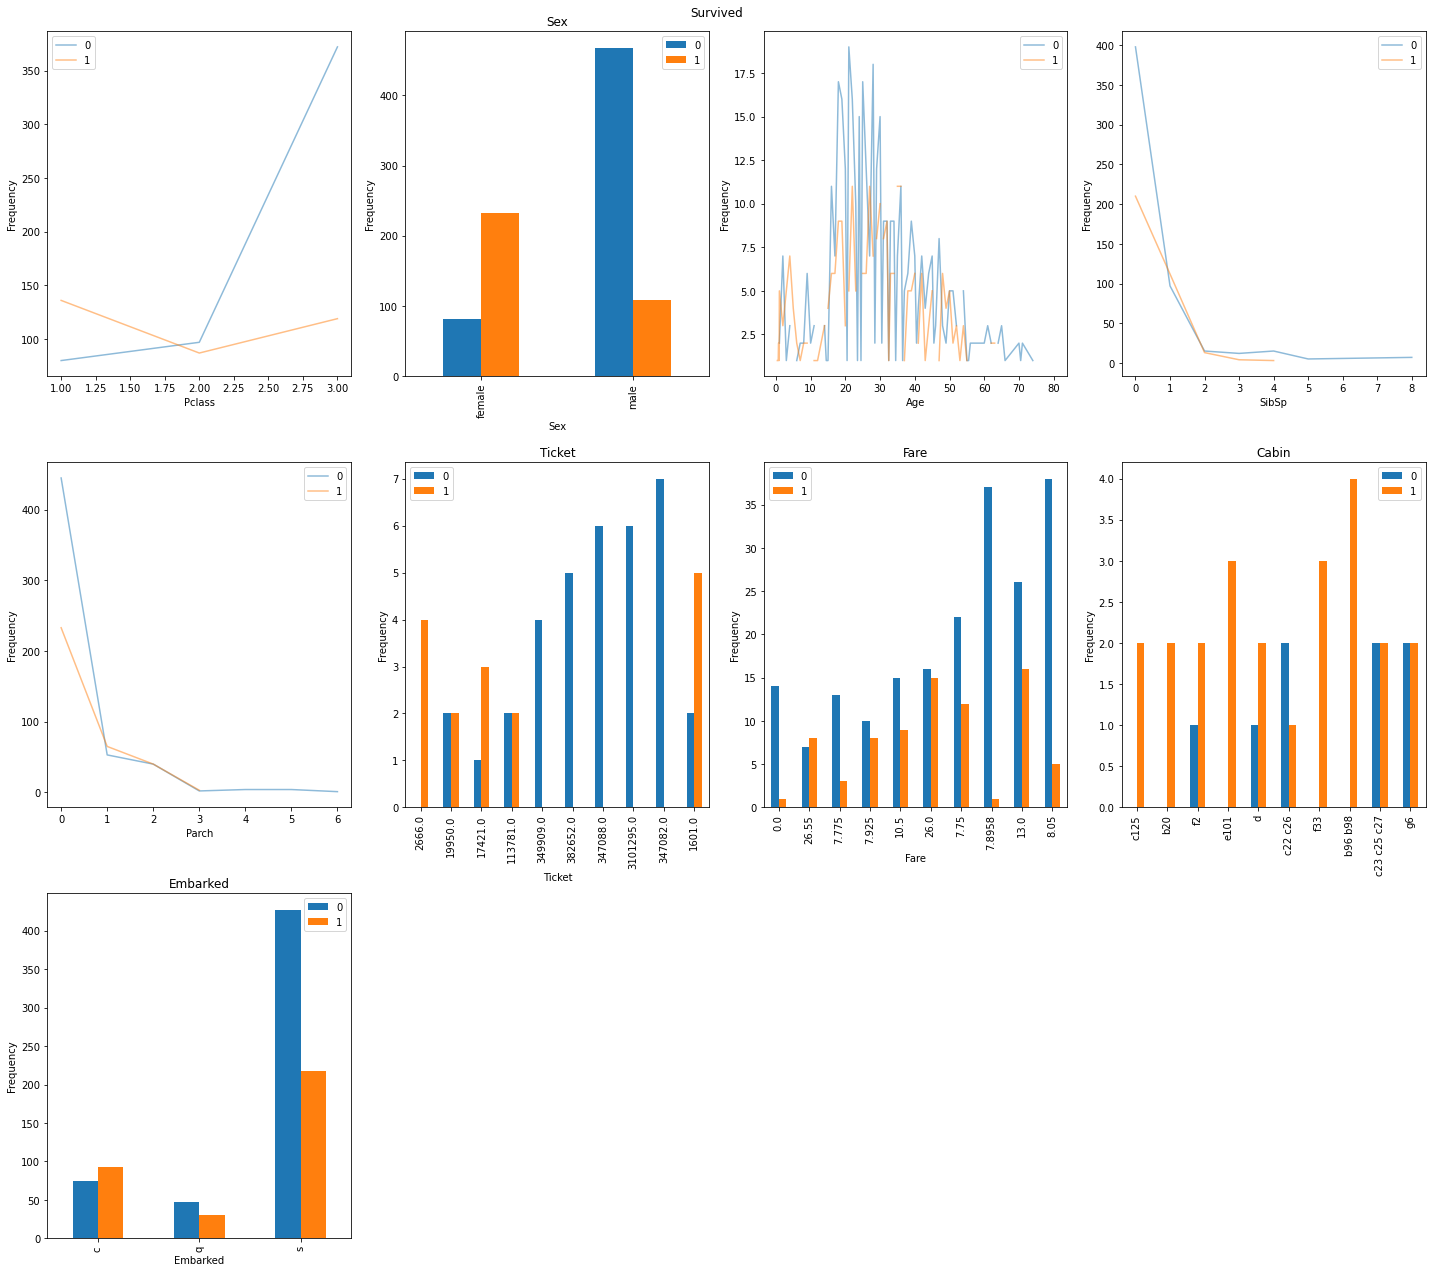

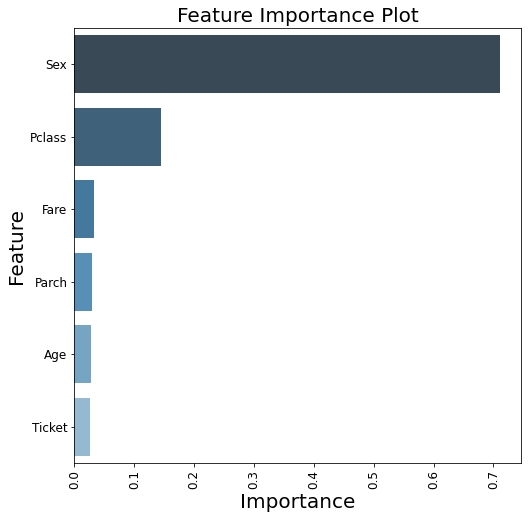

Feature Selection Plot Time taken : 2.0851263999938965

 #### DECISION TREE VISUALIZATION ####
value=[n1,n2,n3...] where n1,n2,n3 are the number of samples of the classes in the order     
value=[0 1]

 #### Printing Sample Equation of the DATA ####
Power term = -2.29719998110336e-10*Age + 1.1704754242552617e-11*Parch + -2.820512858585984e-06*Ticket + 8.98825710189298e-10*Fare + 6.259155843706783e-12*Pclass + 1.957428406792159e-11*Sex + -3.814406007016827e-12

Probability(Y=1) = exp(Power term)/(exp(Power term) + 1)

 #### DONE ####

 #### NORMALIZATION ####
 #### DONE ####

 #### POWER TRANSFORMATIONS ####
 #### DONE ####

 #### SAVING MODEL INFORMATION ####
 #### DONE ####

 TOTAL TRAINING DATA CLEANING AND PLOTS : 5.025929689407349

	 #### VALIDATION AND SCORING ZONE ####




 #### TRANSFORMATION AND PREDICTION ####

 #### PRINTING THE LIST OF COLUMNS AND ITS TYPES THAT ENTER THE MODEL TRAINING ####
#### PRINTING X_test ####
Index(['Age', 'Parch', 'Ticket', 'Fare', 'Pclass', 'Sex'], dtype='object')
Age       float64
Parch     float64
Ticket    float64
Fare      float64
Pclass    float64
Sex       float64
dtype: object


         Age     Parch    Ticket      Fare    Pclass       Sex
0   2.497351 -0.570532  0.173194 -0.377727  0.729206 -0.731083
1   2.871353  1.688430 -0.779012  1.490632  1.350350 -0.731083
2   0.102515 -0.570532  0.193726 -2.418829  0.729206 -0.731083
3  -1.328339 -0.570532 -0.111606  1.608904  0.729206 -0.731083
4  -0.424958 -0.570532  1.193510 -1.070455 -0.891307 -0.731083
5   1.727942 -0.570532  0.147057 -0.428281  0.729206 -0.731083
6  -0.544133 -0.570532  1.481159 -0.136195 -0.891307 -0.731083
7  -4.193493  1.826411  1.183178  0.778124 -0.891307  1.367833
8  -1.188473 -0.570532 -0.111606 -0.703654  0.729206 -0.731083
9  -1.052548 -0.5

job exception: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.



  0%|                                                                            | 0/2 [00:00<?, ?trial/s, best loss=?]


BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.

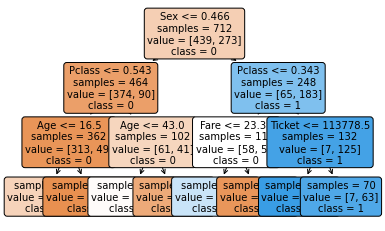

In [30]:
te = time.time()
try:
    if info:
        ################## TRAINING INIT ##################
        df = importFile(path,nrows=None)
        tts = time.time()
        init_info,validation = INIT(df,info)
        tte = time.time()
        print('\n TOTAL TRAINING DATA CLEANING AND PLOTS : {}'.format(tte-tts))
        ################## TRAINING INIT ##################    

        if isinstance(validation,pd.DataFrame):
            ################## VALIDATION AND PREDICTION ##################
            validate(validation,init_info)
            ################## VALIDATION AND PREDICTION ##################
            print('\n\t #### CODE EXECUTED SUCCESSFULLY ####')
            print('\n\t #### END ####')
        else:
            print('\n\t #### CODE DID NOT RUN COMPLETELY ####')
except KeyboardInterrupt:
    print('QUITTING!')
ee = time.time()
print('\n#### TOTAL TIME TAKEN : {} ####'.format(ee-te))

**Preview**

In [ ]:
# View Preview Here
pd.read_csv('preview.csv')

# Model Information

In [ ]:
joblib.load('ALL INFORMATION')['model_info'].drop(['model','param','accuracy'],axis=1)

In [ ]:
# validate(validation,init_info)